In [ ]:
from notebooks import *

In [ ]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(skimr))
suppressMessages(library(ggmap))
suppressMessages(library(rnaturalearth))

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 17969 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


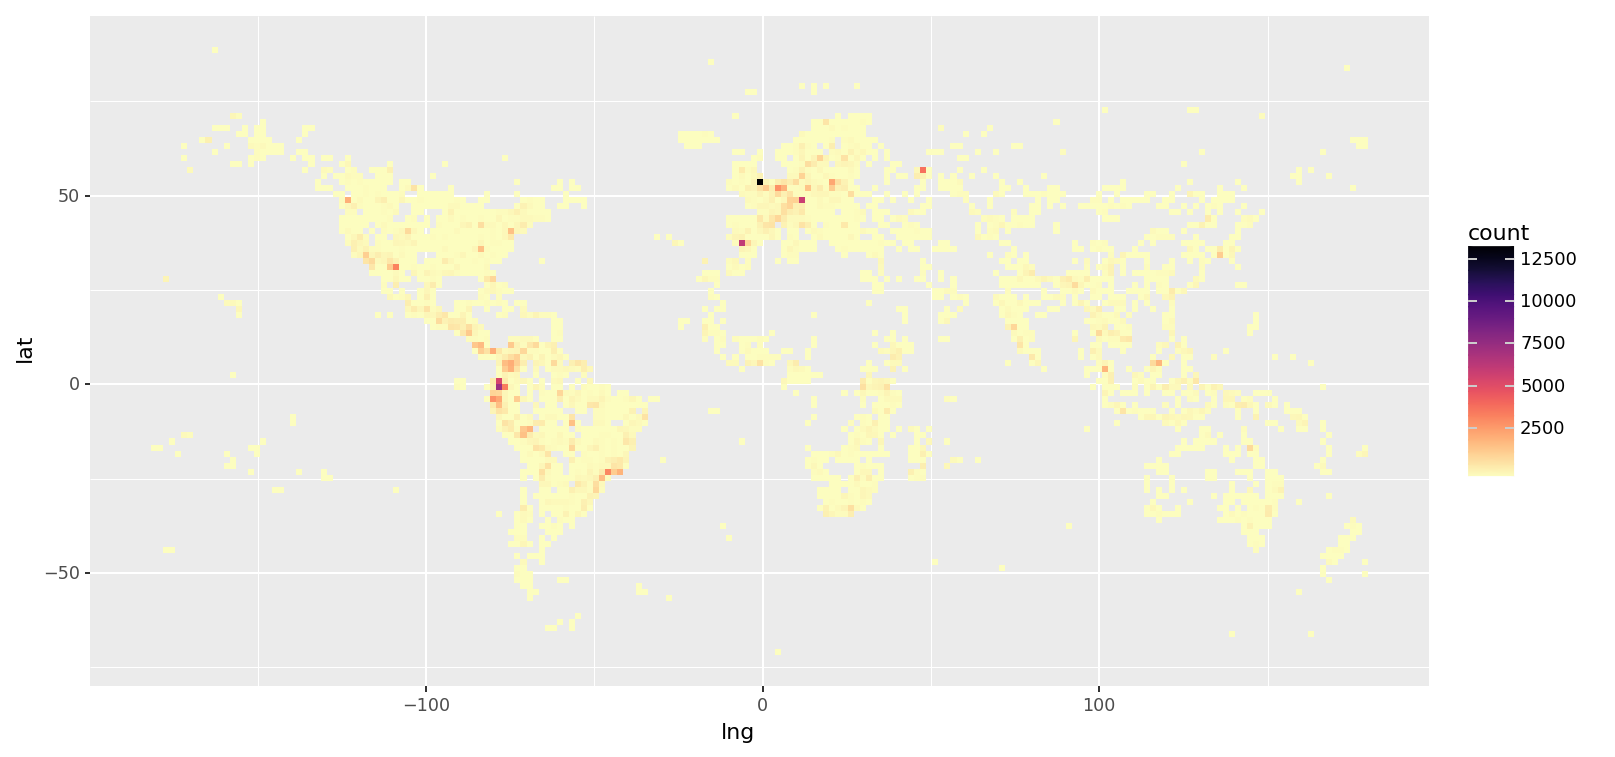

<ggplot: (-9223372036531414889)>

In [ ]:
(xc.metadata
    .pipe(ggplot, aes(x='lng', y='lat'))
    + geom_bin2d(bins=(200, 100))
    + scale_fill_cmap(mpl.cm.magma_r)
    + theme_figsize(aspect_ratio=1/2)
)

In [ ]:
xc_latlng = xc.metadata[['lat', 'lng']]
%Rpush xc_latlng

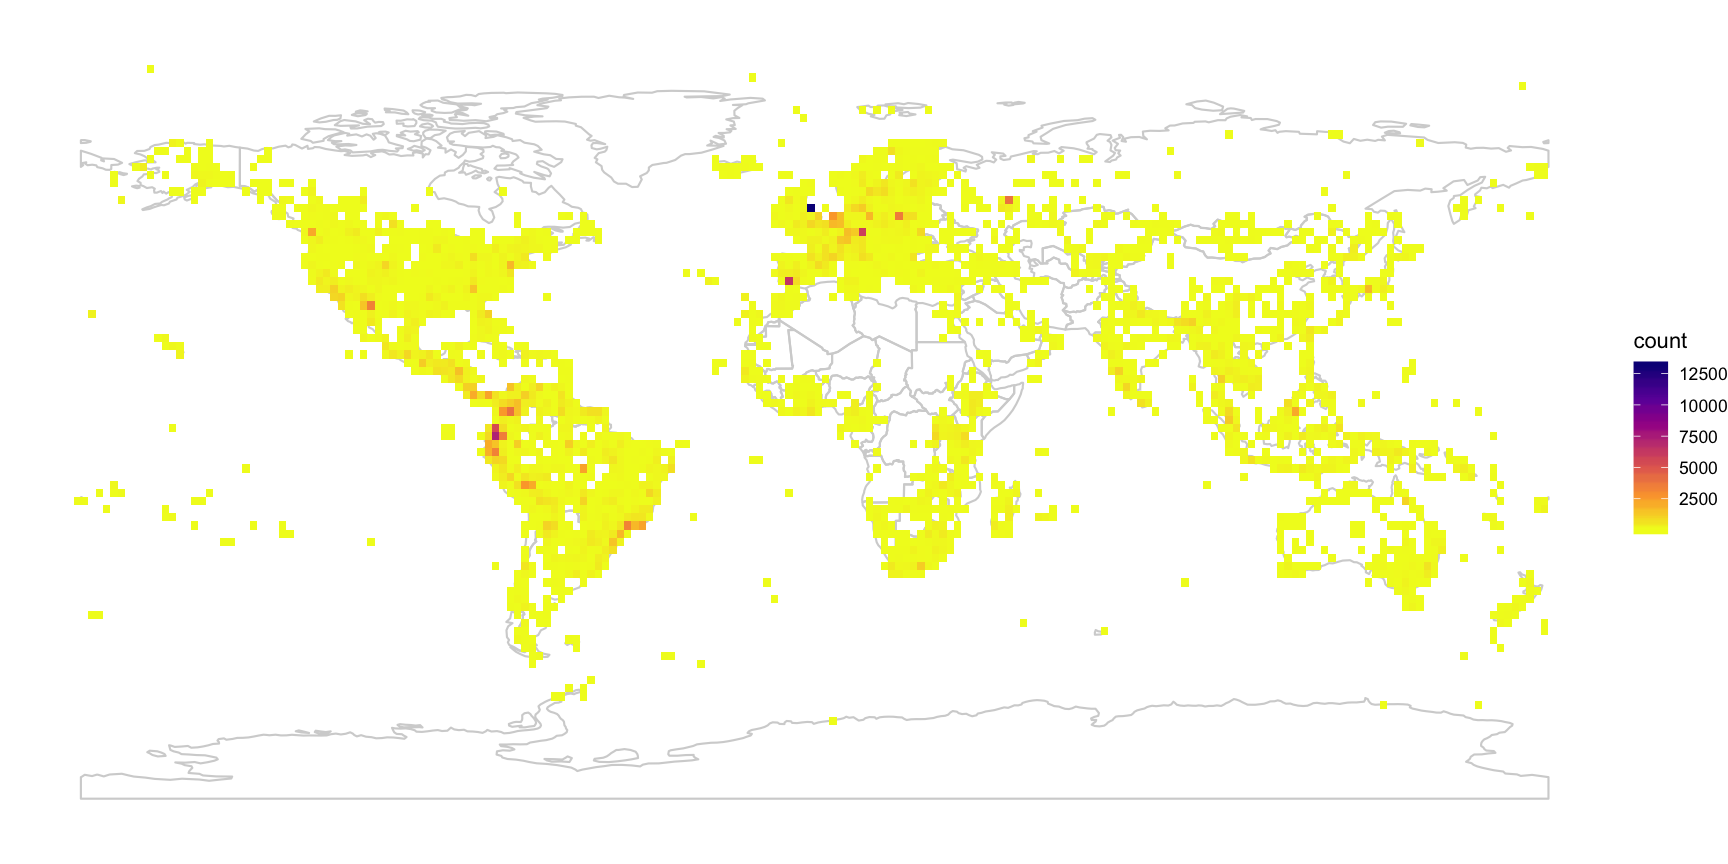

In [ ]:
%%R -w12 -h6
(xc_latlng
    %>% ggplot(aes(lng, lat))
    + geom_sf(aes(NULL, NULL), data = ne_countries(returnclass = "sf"), color = "lightgray", fill = NA)
    + geom_bin2d(bins = c(5, 2) * 40)
    + scale_fill_viridis_c(option = "plasma", direction = -1)
    + coord_sf(datum = NA) # NA to remove gridlines (until https://github.com/tidyverse/ggplot2/issues/2389)
    + theme_void()
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Regions defined for each Polygons

  warnings.warn(x, RRuntimeWarning)


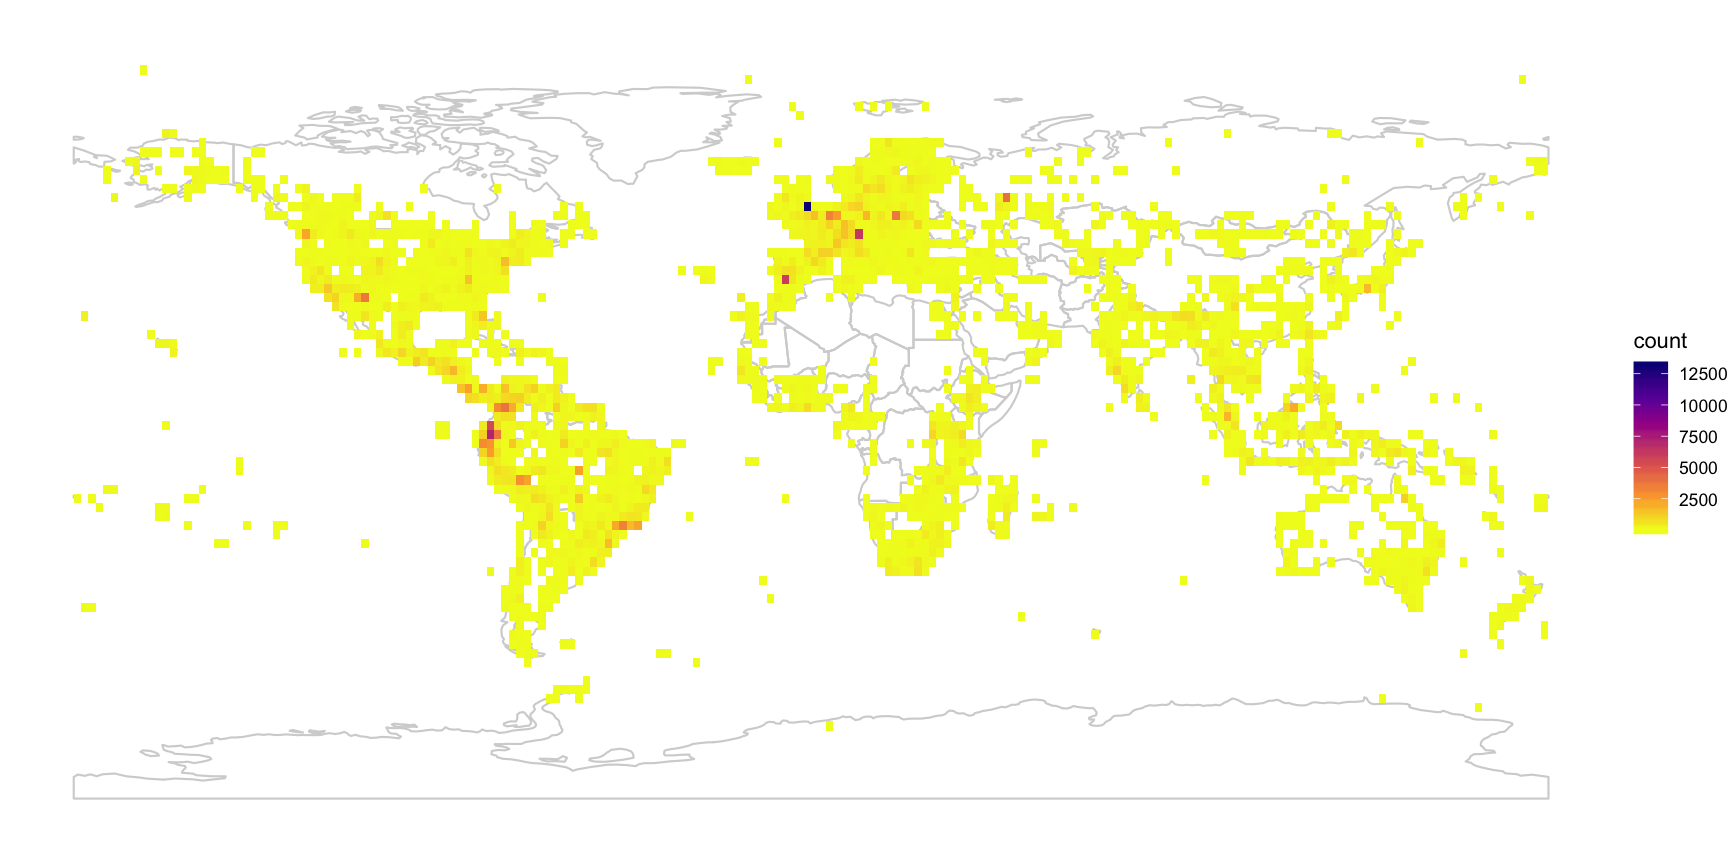

In [ ]:
%%R -w12 -h6
# Here's how to simulate geom_sf manually, e.g. in case we want to try mappping it back out to python [good luck!]
#   - From https://bhaskarvk.github.io/user2017.geodataviz/notebooks/02-Static-Maps.nb.html
shapes <- ne_countries()
{{shapes@data$id <- row.names(shapes@data)}}
shapes.tidy <- broom::tidy(shapes)
shapes.tidy <- dplyr::left_join(shapes.tidy, shapes@data, by = 'id')
(xc_latlng
    %>% ggplot(aes(lng, lat))
    + geom_polygon(aes(long, lat, group = group), data = shapes.tidy, color = "lightgray", fill = NA)
    + geom_bin2d(bins = c(5, 2) * 40)
    + scale_fill_viridis_c(option = "plasma", direction = -1)
    + coord_quickmap()
    + theme_void()
)

# WARNING: Real maps are pretty, but they're a HUGE timesink. Proceed at your own risk!

In [ ]:
%%R
if (!exists("get_stamenmap_")) get_stamenmap_ <- get_stamenmap
if (!exists("get_googlemap_")) get_googlemap_ <- get_googlemap
get_stamenmap <- function(...) suppressMessages(get_stamenmap_(..., color = "bw", maptype = "terrain-background"))
get_googlemap <- function(...) suppressMessages(get_googlemap_(..., color = "bw", maptype = "terrain"))

In [ ]:
%%R
geocode_to_c <- function(x) x %>% select(lon, lat) %>% as.numeric
locs <- list(
    center = list(
        tilden_park_ca = geocode_to_c(geocode('tilden park ca'))
    ),
    bbox = list(
        us = c(left = -125, bottom = 25.75, right = -67, top = 49)
    )
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Source : https://maps.googleapis.com/maps/api/geocode/json?address=tilden%20park%20ca

  warnings.warn(x, RRuntimeWarning)


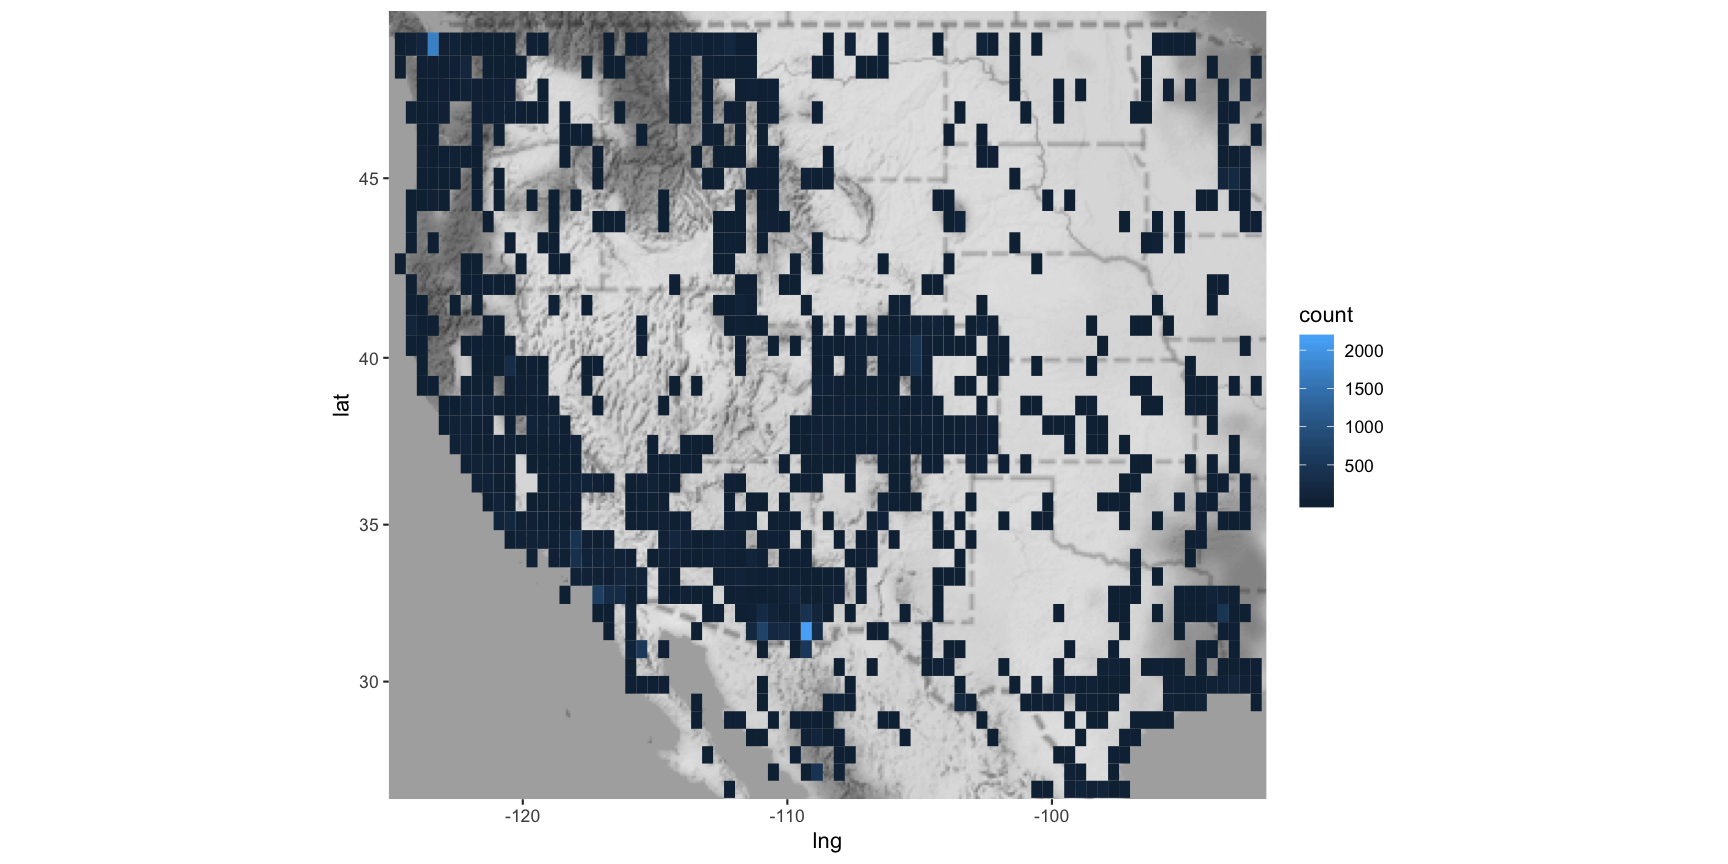

In [ ]:
%%R -w12 -h6 -i xc_latlng
(
    # locs$bbox$us
    # c(-138.999023,29.516110,-102.084961,45.890008)
    c(-125.068359,26.076521,-91.889648,49.296472)
    %>% get_stamenmap(zoom = 4)
    %>% ggmap
    %+% xc_latlng
    + aes(x = lng, y = lat)
    + geom_bin2d(bins = c(40*2, 40))
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Coordinate system already present. Adding new coordinate system, which will replace the existing one.

  warnings.warn(x, RRuntimeWarning)


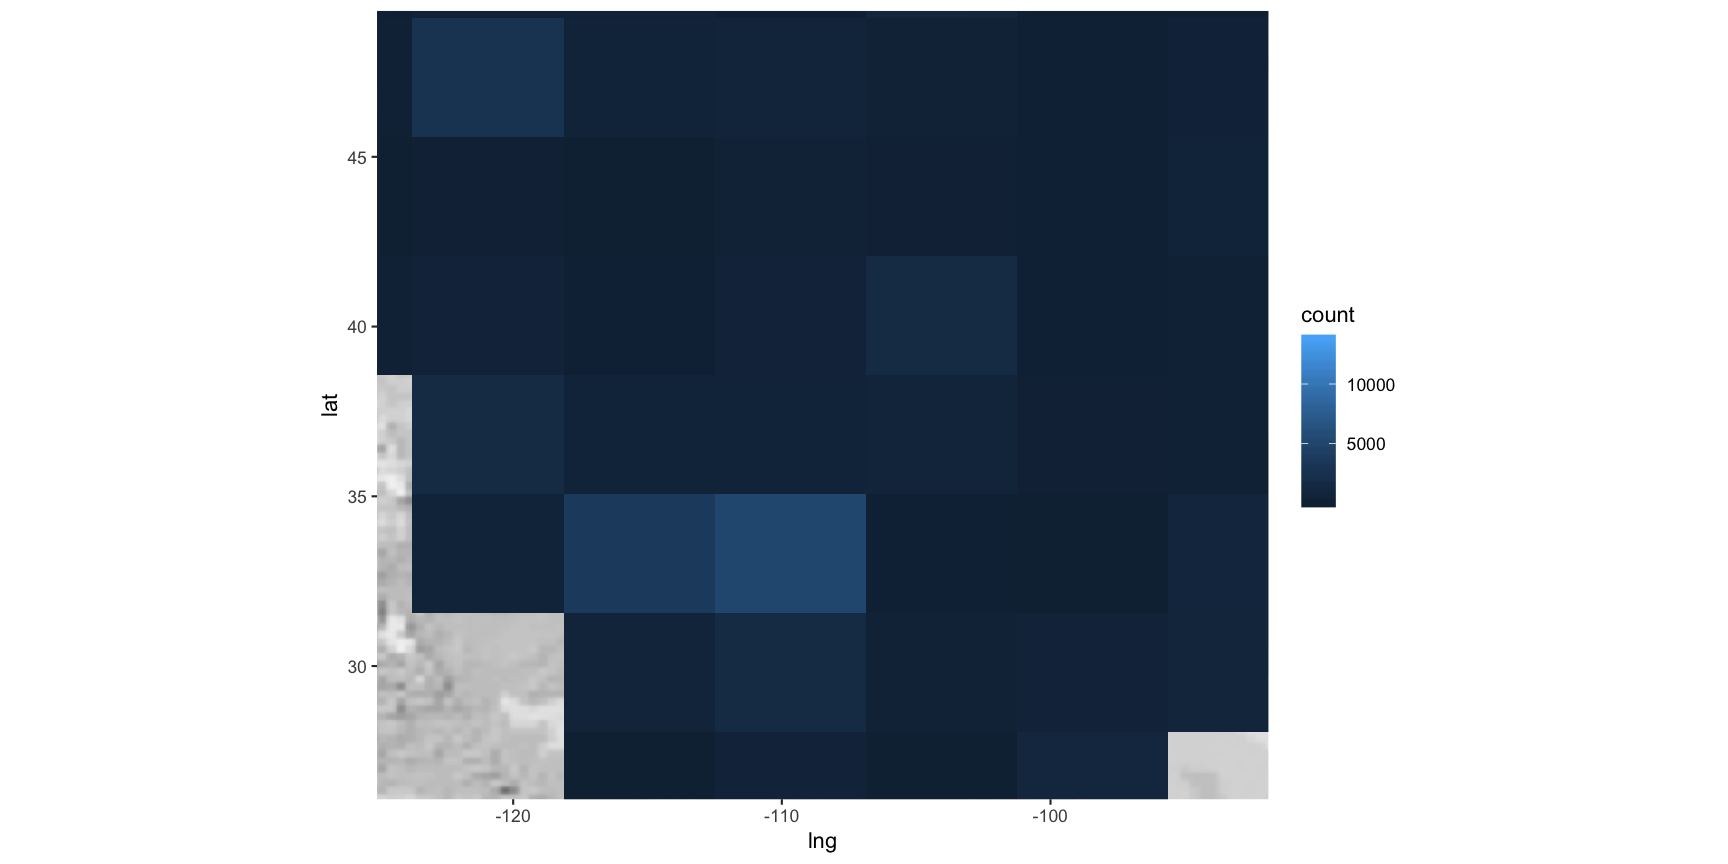

In [ ]:
%%R -w12 -h6 -i xc_latlng
(
    locs$center$tilden_park_ca
    %>% get_googlemap(zoom = 1, size = c(640/1, 640/2))
    %>% ggmap
    %+% xc_latlng
    + aes(x = lng, y = lat)
    + geom_bin2d(bins = c(40*2, 40))
    # + geom_point()
    # + geom_count()
    # + coord_map()
    + coord_quickmap(xlim = c(-125.068359,-91.889648), ylim = c(26.076521,49.296472))
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 17969 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


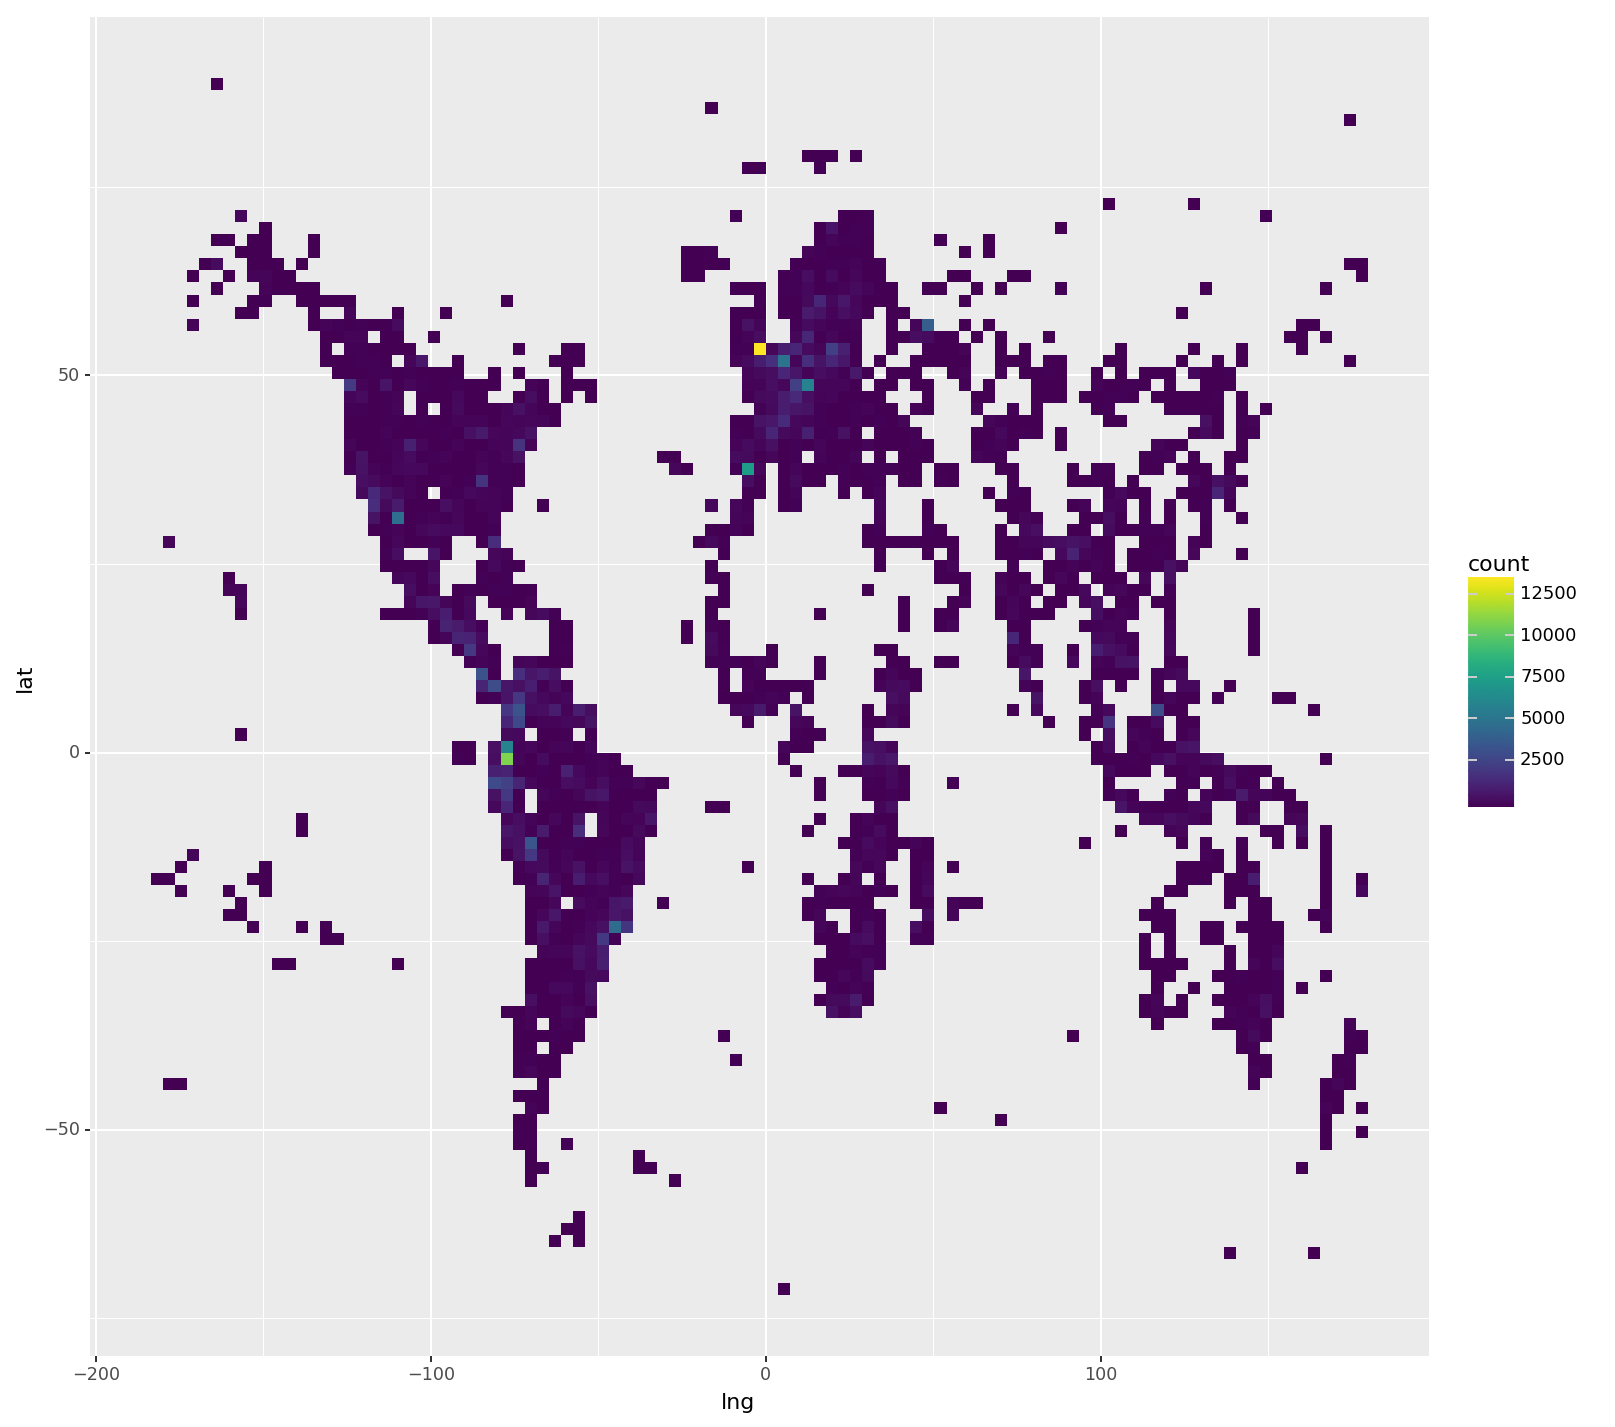

<ggplot: (-9223372036527765472)>

In [ ]:
(xc.metadata
    .pipe(ggplot, aes(x='lng', y='lat'))
    + geom_bin2d(bins=100)
    + theme_figsize(aspect_ratio=1/1)
)

In [ ]:
# Slow (~30s)
# display(
#     df_summary(xc.metadata).T,
#     xc.metadata.sample(100, random_state=0).sort_values('id'),
# )

In [ ]:
robjects.globalenv['species_levels'] = robjects.vectors.StrVector(xc.metadata.species.cat.categories)
robjects.globalenv['quality_levels'] = robjects.vectors.StrVector(xc.metadata.quality.cat.categories)
xc_metadata_ = (xc.metadata
    # [:1000]  # Faster dev
    # Filter down to the cols we're currently using in R, to avoid a ~30s bottleneck in %Rpush
    [['downloaded', 'species', 'lat', 'lng', 'quality', 'date']]
    .pipe(df_cat_to_str)  # Cats fail to convert
    .astype({'date': 'str'})  # Datetimes fail to convert
)

In [ ]:
%Rpush xc_metadata_

In [ ]:
%%R
xc_metadata <- (xc_metadata_
    %>% mutate(
        species = factor(species, levels = species_levels),
        quality = factor(quality, levels = quality_levels),
        date = as.Date(date)
    )
)
# print(skim(xc_metadata))  # Slow, big, but informative when needed
# xc_metadata %>% sample_n(5)

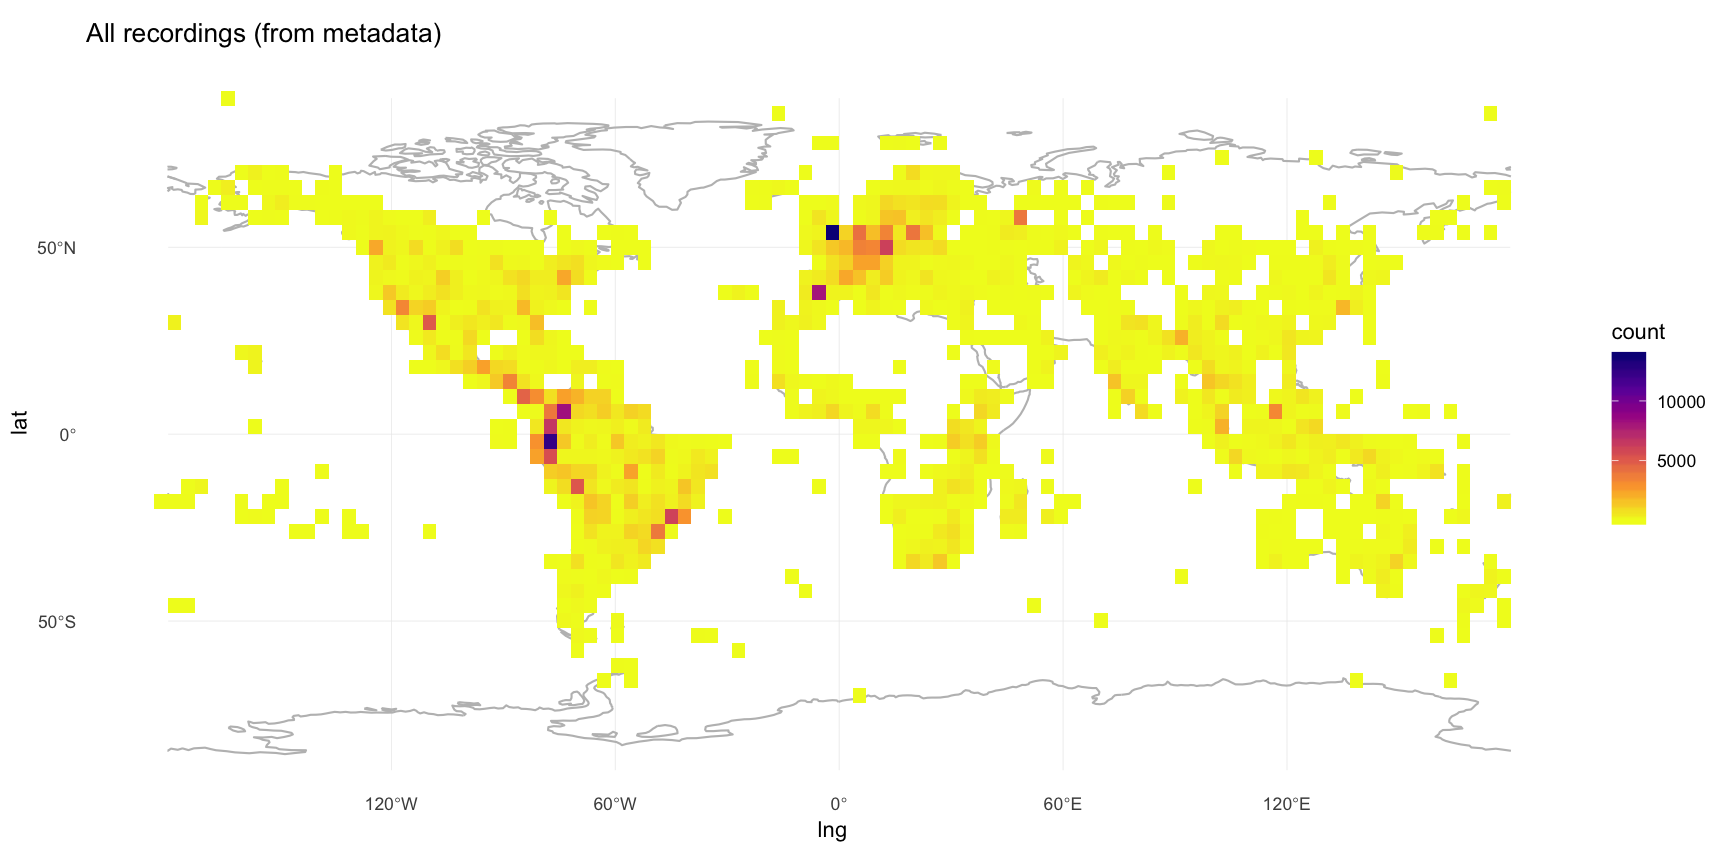

In [ ]:
%%R -w12 -h6
(xc_metadata
    %>% ggplot(aes(lng, lat))
    + geom_sf(aes(NULL, NULL), data = ne_coastline(returnclass = "sf"), color = "gray")
    + geom_bin2d(bins = c(100, 40))
    # + geom_bin2d(bins = c(200, 80))
    + coord_sf()
    + scale_fill_viridis_c(option = "plasma", direction = -1)
    + theme_minimal()
    + ggtitle("All recordings (from metadata)")
)

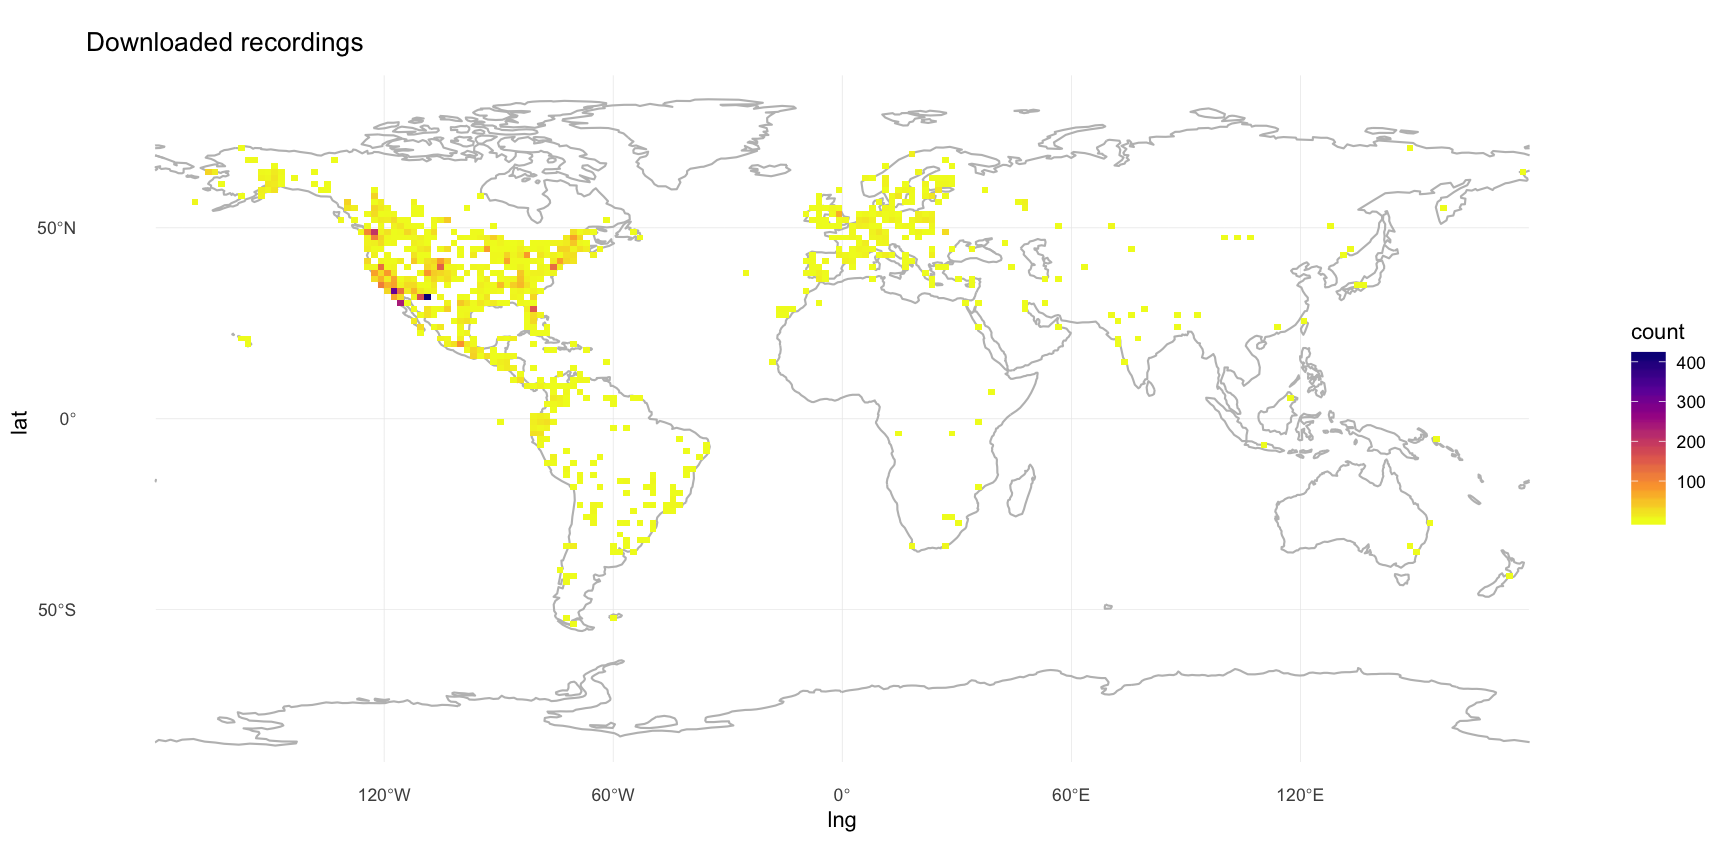

In [ ]:
%%R -w12 -h6
(xc_metadata
    %>% filter(downloaded == TRUE)
    %>% ggplot(aes(lng, lat))
    + geom_sf(aes(NULL, NULL), data = ne_coastline(returnclass = "sf"), color = "gray")
    + geom_bin2d(bins = c(5, 2) * 40)
    + coord_sf()
    + scale_fill_viridis_c(option = "plasma", direction = -1)
    + theme_minimal()
    + ggtitle("Downloaded recordings")
)

In [ ]:
%%R -o map
map_raw <- ne_coastline(scale = "small")
{{map_raw@data$id <- row.names(map_raw@data)}}
map <- dplyr::left_join(broom::tidy(map_raw), map_raw@data, by = 'id')

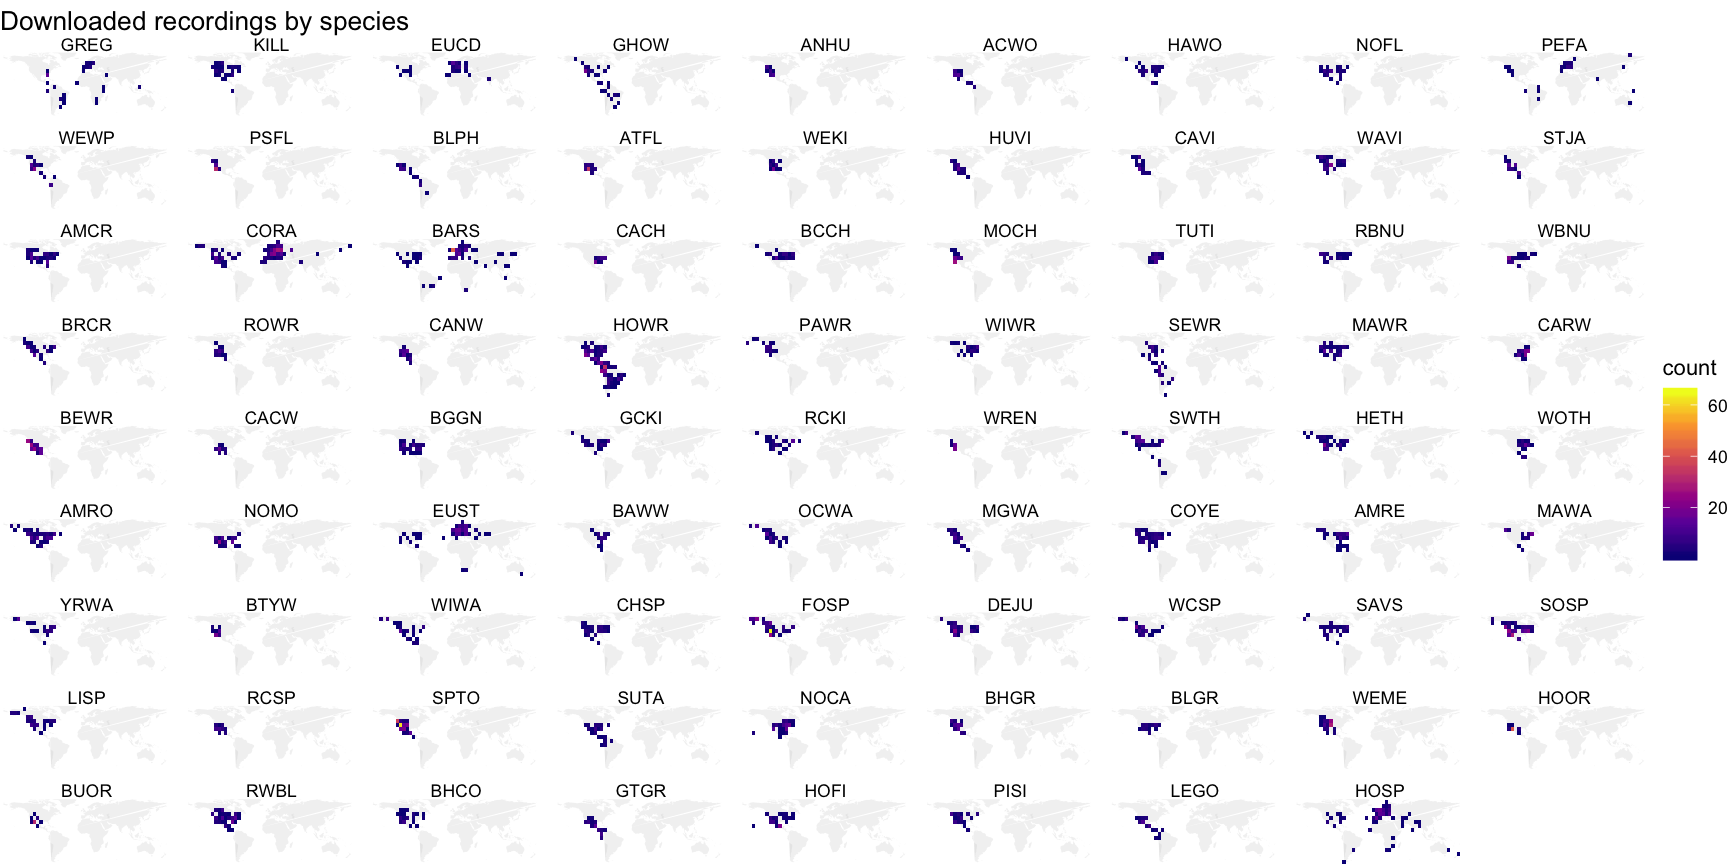

In [ ]:
%%R -w12 -h6
df <- (xc_metadata
    %>% filter(downloaded == TRUE)
    %>% group_by(species)
    %>% mutate(n = n()) %>% arrange(desc(n)) # Sort species groups by num recs (desc)
    %>% nest %>% slice(0:80) %>% unnest # Take the first k species groups, so we don't blow up facet_wrap
    %>% ungroup()
)
(df
    %>% ggplot(aes(lng, lat))
    + facet_wrap(~species)
    + geom_polygon(aes(long, lat, group = group), data = map, alpha = 0.3, color = NA, fill = "lightgray")
    + geom_bin2d(bins = c(5, 2) * 10)
    + scale_fill_viridis_c(option = "plasma", direction = 1)
    + coord_cartesian(
        xlim = c(min(df$lng, na.rm = TRUE), max(df$lng, na.rm = TRUE)),
        ylim = c(min(df$lat, na.rm = TRUE), max(df$lat, na.rm = TRUE))
    )
    + theme_void()
    + ggtitle("Downloaded recordings by species")
)

In [ ]:
df = (xc.metadata
    [lambda df: df.downloaded]
    .astype({'species': 'str'})
    .groupby('species').apply(lambda g: g.assign(n=len(g)))
    .sort_values(['n', 'species'], ascending=False)
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin_2d : Removed 70 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


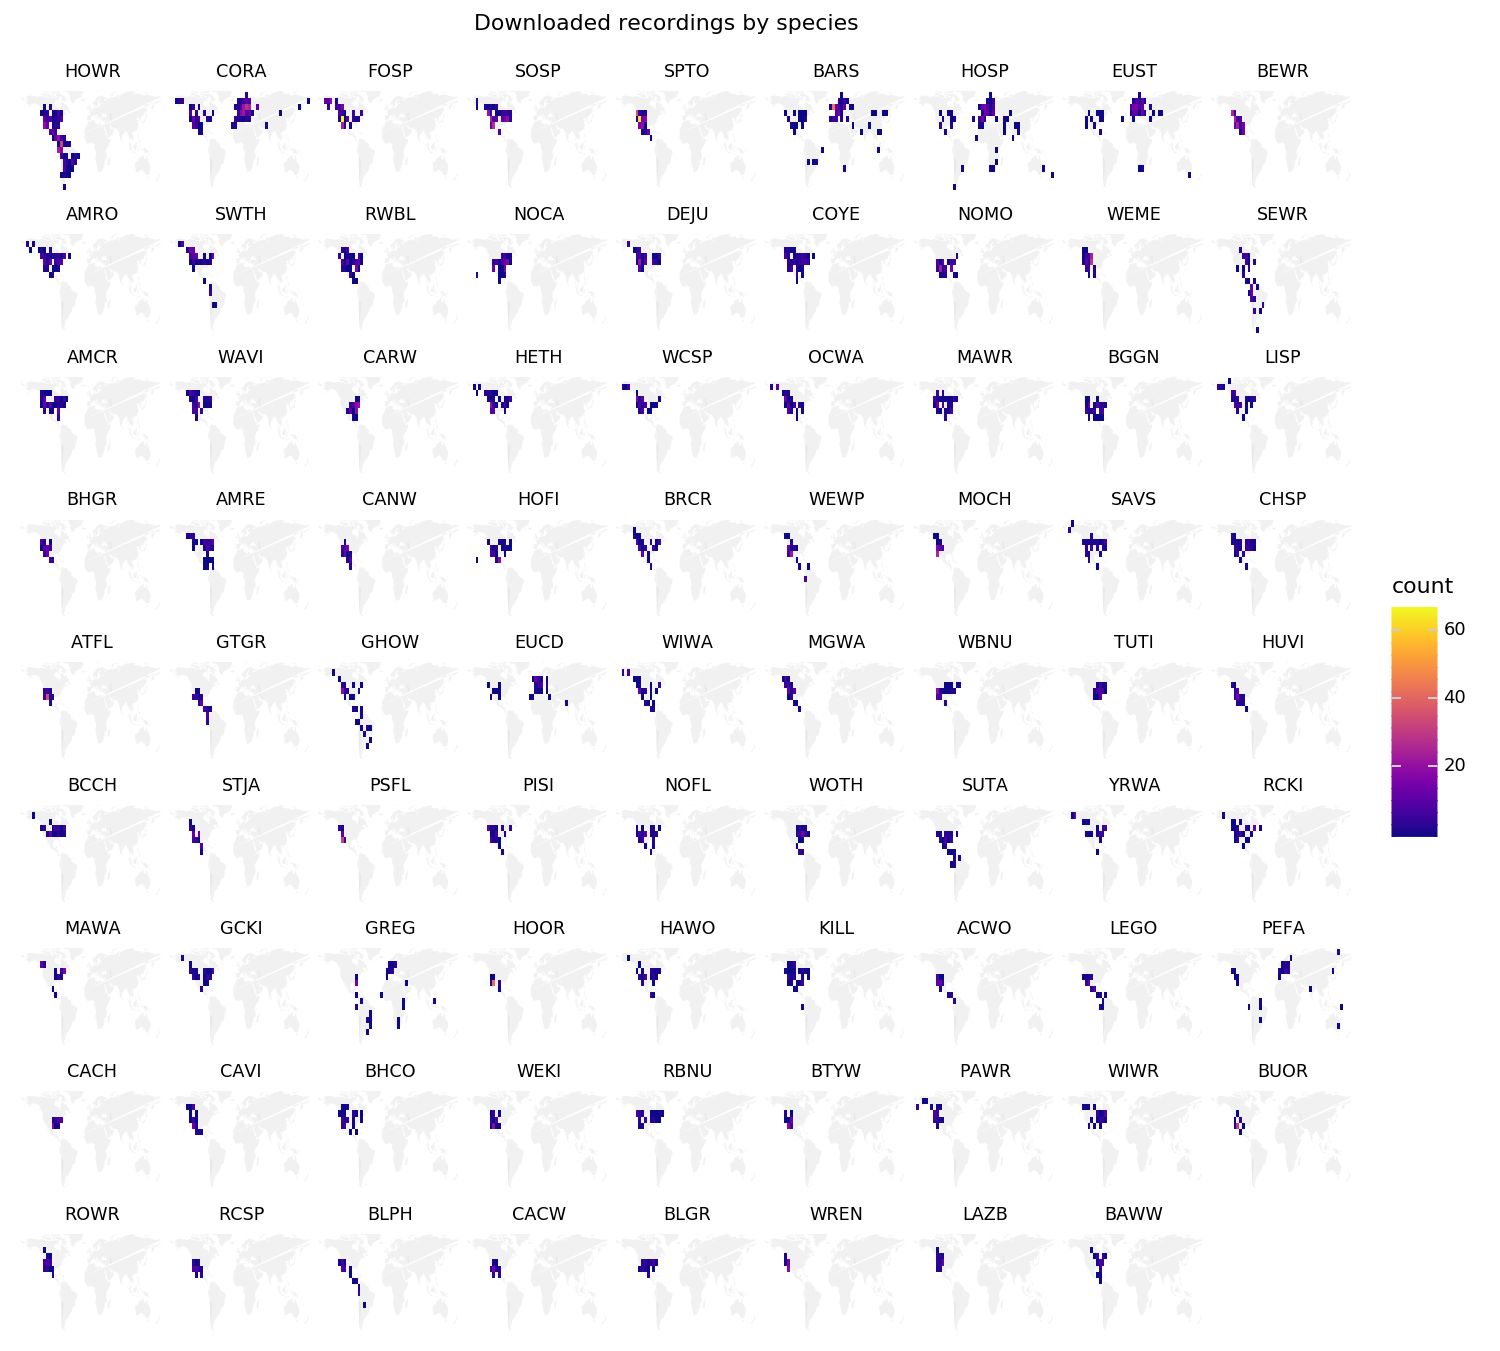

<ggplot: (331540302)>

In [ ]:
(df
    [lambda df: df.species.isin(df.species.unique()[:80])]  # Take top k species
    .pipe(df_ordered_cat, species=lambda df: df.species.unique())  # Sort facets by k
    # .pipe(df_ordered_cat, species=xc.metadata.species.cat.categories)  # Sort facets taxomonically
    .pipe(ggplot, aes(x='lng', y='lat'))
    + facet_wrap('species')
    + geom_polygon(aes(x='long', y='lat', group='group'), data=map, alpha=.3, fill='lightgray')
    + geom_bin2d(bins=np.array([5, 2]) * 10)
    + scale_fill_cmap(mpl.cm.plasma)
    + coord_cartesian(xlim=(df.lng.min(), df.lng.max()), ylim=(df.lat.min(), df.lat.max()))
    + theme_void()
    + theme_figsize(width=12, aspect_ratio=2/3)
    + ggtitle("Downloaded recordings by species")
)